In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from darwinian_shift import DarwinianShift
from darwinian_shift import CDFMonteCarloTest, BinomTest
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup, UniprotLookup
from darwinian_shift import hide_top_and_right_axes, get_bins_for_uniprot_features, plot_domain_structure
from darwinian_shift import plot_scatter_two_scores

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [3]:
d_skin = DarwinianShift(
    data = pd.read_excel('248092_3_supp_6645104_q35h43.xlsx', sheet_name='Table S4', skiprows=4),
    source_genome='GRCh37',
    spectra='skin_trinuc_spectrum.txt',
    included_mutation_types='missense'
)

In [4]:
d_oe = DarwinianShift(
    data=pd.read_excel('aau3879_TableS2.xlsx',
                       sheet_name='Mutations_collapsed_by_distance', skiprows=17),
    source_genome='GRCh37',
    spectra='oesophagus_trinuc_spectrum.txt',
    included_mutation_types='missense'
)

# Mutations per domain

In [5]:
# Colours 
egf_colour = '#88CCEE'
egf_11_12_colour = '#0077BB'
LNR_colour = '#EE7733'
ANK_colour = '#009988'
transmembrane_colour = '#CC3311'
non_domain_colour = '#888888'  #'#BBBBBB'

In [6]:
# Use uniprot data to define domain boundaries
u = UniprotLookup()

In [7]:
notch2_skin = d_skin.make_section(gene='NOTCH2')
notch2_oe = d_oe.make_section(gene='NOTCH2')

In [8]:
last_residue = notch2_skin.null_mutations['residue'].max()

In [9]:
NOTCH2_uniprot = u.get_uniprot_data('ENST00000256646')

bins, types, descriptions = get_bins_for_uniprot_features(NOTCH2_uniprot, min_gap=1, last_residue=last_residue, 
                                                         feature_types=['domain', 'transmembrane region', 'repeat'])
colours = []
for t, desc in zip(types, descriptions):
    if desc in ['EGF-like 11; calcium-binding', 'EGF-like 12; calcium-binding']:
        colours.append(egf_11_12_colour)
    elif t == 'domain':
        colours.append(egf_colour)
    elif t == 'repeat':
        if 'LNR' in desc:
            colours.append(LNR_colour)
        elif 'ANK' in desc:
            colours.append(ANK_colour)
    elif t == 'transmembrane region':
        colours.append(transmembrane_colour)
    elif t is None and desc is None:
        colours.append(non_domain_colour)
        
colours_domain_plot = [None if c == non_domain_colour else c for c in colours]

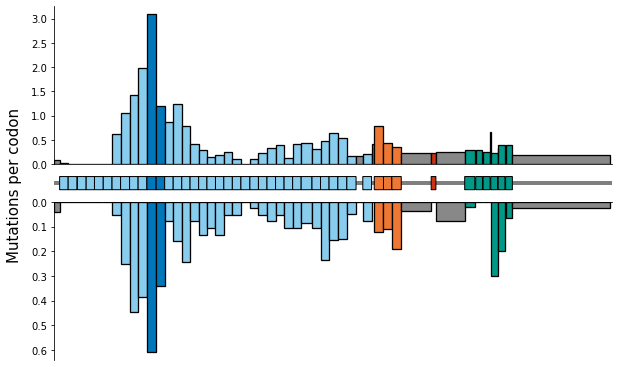

In [10]:
fig, (ax1, ax_dom, ax2) = plt.subplots(3, 1, figsize=(10, 6.5), sharex=True, 
                                       gridspec_kw={'height_ratios': (3, 0.5, 3), 'hspace': 0.05})
linewidth = 1.3
notch2_skin.plot_bar_observations(figsize=(10, 3), binning_regions=bins, 
             normalise_by_region_size=True, facecolour=colours, linewidth=linewidth, ax=ax1)
ax1.set_xlim([0, last_residue+10])
hide_top_and_right_axes(ax1)
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')

notch2_oe.plot_bar_observations(figsize=(10, 3), binning_regions=bins, 
             normalise_by_region_size=True, facecolour=colours, linewidth=linewidth, ax=ax2)
ax2.set_xlim([0, last_residue+10])
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.invert_yaxis()
ax2.set_xticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')

plot_domain_structure(bins, colours_domain_plot, height=1, ax=ax_dom)

fig.text(0.06, 0.5, 'Mutations per codon', va='center', rotation='vertical', fontsize=15);

# Selection

In [11]:
# Directories
sifts_directory="SIFTS_files"
pdb_directory = "PDB_files"

# Colours
unobserved_colour = '#BBBBBB'  
observed_colour = '#EE7733'
foldx_expected_colour = '#EE6677'
foldx_observed_colour = '#CC3311'
interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'
calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

In [12]:
# Define the region to test
notch2_section_definition_egf11_12 = {
    'transcript_id': 'ENST00000256646', 'pdb_id': '5mwb', 'pdb_chain': 'A', 
    'start': 415, 'end': 492, # Restrict to the residues in EGF11-12
    'interface_residues': [418, 421, 424, 425, 426, 428, 429, 439, 440, 452, 454, 456, 470, 472, 473, 481],
    'ca_binding_residues': [415, 416, 418, 435, 436, 439, 456, 457, 459, 473, 474]
}

## Define the metrics

### Individual metrics

In [13]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="FoldX_results",
                   sifts_directory=sifts_directory,
                   foldx_file_name_start="PS_f*", download_sifts=True)

# Define a lookup object which determines whether mutations are on the NOTCH2-ligand interface. 
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

ca_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean binding/not binding. 
    target_key='ca_binding_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='Calcium binding'  # Label to appear on plot axes
)

### Conditional tests 

In [14]:
# First define a lookup that is 1 if the mutation is on the interface and or calcium binding
interface_or_ca_lookup = ORLookup(
    lookups=[interface_lookup, ca_lookup],  
    thresholds=[0.5, 0.5],  # Set thresholds at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for interface or calcium binding.
)


# Define the combined lookup.
excllook_foldx = MutationExclusionLookup(
    lookup=fold,   # Use the calcium binding lookup for the test
    exclusion_lookup=interface_or_ca_lookup,
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=fold.name
)

In [15]:
# First define a lookup that is 1 if the mutation is destabilising or calcium binding
destabilising_or_ca_lookup = ORLookup(
    lookups=[fold, ca_lookup],  
    thresholds=[2, 0.5],  # Use 2kcal/mol as the ∆∆G threshold. Ca score is 0 or 1, so set threshold at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for calcium binding or > 2 for ∆G.
)

# Define the combined lookup.
excllook_interface = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the inteface lookup for the test
    exclusion_lookup=destabilising_or_ca_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=interface_lookup.name
)

In [16]:
# First define a lookup that is 1 if the mutation is destabilising or on the interface and 0 otherwise.
destabilising_or_interface_lookup = ORLookup(
    lookups=[fold, interface_lookup],  # Use the FoldX and the interface lookups.  
    thresholds=[2, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are both 1.
)


# Define the combined lookup.
excllook_ca = MutationExclusionLookup(
    lookup=ca_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=destabilising_or_interface_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=ca_lookup.name
)

## Skin

FoldX test excluding interface and calcium binding mutations

In [17]:
s = d_skin.run_section(notch2_section_definition_egf11_12, lookup=excllook_foldx, 
                      statistics=CDFMonteCarloTest(num_draws=100000))

In [18]:
s.get_results_dictionary()

{'gene': 'NOTCH2',
 'transcript_id': 'ENST00000256646',
 'chrom': '1',
 'section_id': '5mwb:A',
 'num_mutations': 98,
 'observed_median': 3.8769,
 'observed_mean': 9.2694815,
 'expected_median_glob_k3': 1.76611,
 'median_shift_glob_k3': 2.1107899999999997,
 'expected_mean_glob_k3': 3.8958263561784214,
 'mean_shift_glob_k3': 5.373655143821578,
 'CDF_MC_glob_k3_num_smaller_or_equal': 100001,
 'CDF_MC_glob_k3_num_larger_or_equal': 1,
 'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05,
 'CDF_MC_glob_k3_cdf_mean': 0.6976231750615607}

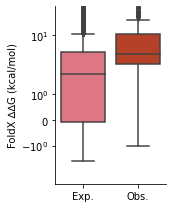

In [19]:
s.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['Exp.', 'Obs.'])
plt.tight_layout()

Ligand-binding interface test excluding high ∆∆G and calcium-binding mutations

In [20]:
s = d_skin.run_section(notch2_section_definition_egf11_12, lookup=excllook_interface, 
                      statistics=BinomTest())

In [21]:
s.get_results_dictionary()

{'gene': 'NOTCH2',
 'transcript_id': 'ENST00000256646',
 'chrom': '1',
 'section_id': '5mwb:A',
 'num_mutations': 48,
 'observed_median': 1.0,
 'observed_mean': 0.5625,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 1.0,
 'expected_mean_glob_k3': 0.2653253802521213,
 'mean_shift_glob_k3': 0.2971746197478787,
 'binom_glob_k3_pvalue': 1.977714302630375e-05,
 'binom_glob_k3_expected_proportion': 0.2653253802521213,
 'binom_glob_k3_observed_proportion': 0.5625,
 'binom_glob_k3_expected_count': 12.735618252101823,
 'binom_glob_k3_observed_count': 27,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 19.0,
 'binom_glob_k3_expected_CI_low': 7.0,
 'binom_glob_k3_observed_CI_low': 20.0,
 'binom_glob_k3_observed_CI_high': 34.0}

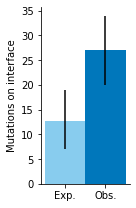

In [22]:
s.plot_binomial(figsize=(2, 3), show_legend=False, colours=[interface_observed_colour, interface_expected_colour])
plt.title("")
plt.ylabel('Mutations on interface')
hide_top_and_right_axes(plt.gca())
plt.tight_layout();

Calcium-binding mutation test excluding high ∆∆G and interface mutations. 

In [23]:
s = d_skin.run_section(notch2_section_definition_egf11_12, lookup=excllook_ca, 
                      statistics=BinomTest())

In [24]:
s.get_results_dictionary()

{'gene': 'NOTCH2',
 'transcript_id': 'ENST00000256646',
 'chrom': '1',
 'section_id': '5mwb:A',
 'num_mutations': 32,
 'observed_median': 0.0,
 'observed_mean': 0.34375,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.13975105424028386,
 'mean_shift_glob_k3': 0.20399894575971614,
 'binom_glob_k3_pvalue': 0.002984622472663585,
 'binom_glob_k3_expected_proportion': 0.1397510542402839,
 'binom_glob_k3_observed_proportion': 0.34375,
 'binom_glob_k3_expected_count': 4.4720337356890845,
 'binom_glob_k3_observed_count': 11,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 9.0,
 'binom_glob_k3_expected_CI_low': 1.0,
 'binom_glob_k3_observed_CI_low': 6.0,
 'binom_glob_k3_observed_CI_high': 16.0}

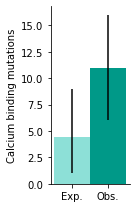

In [25]:
s.plot_binomial(figsize=(2, 3), show_legend=False, colours=[calcium_observed_colour, calcium_expected_colour])
plt.title("")
plt.ylabel('Calcium binding mutations')
hide_top_and_right_axes(plt.gca())
plt.tight_layout();

## Oesophagus

FoldX test excluding interface and calcium binding mutations

In [26]:
s = d_oe.run_section(notch2_section_definition_egf11_12, lookup=excllook_foldx, 
                      statistics=CDFMonteCarloTest(num_draws=100000))

In [27]:
s.get_results_dictionary()

{'gene': 'NOTCH2',
 'transcript_id': 'ENST00000256646',
 'chrom': '1',
 'section_id': '5mwb:A',
 'num_mutations': 25,
 'observed_median': 4.7953,
 'observed_mean': 10.04823932,
 'expected_median_glob_k3': 1.75118,
 'median_shift_glob_k3': 3.0441200000000004,
 'expected_mean_glob_k3': 4.521538266322293,
 'mean_shift_glob_k3': 5.526701053677708,
 'CDF_MC_glob_k3_num_smaller_or_equal': 99999,
 'CDF_MC_glob_k3_num_larger_or_equal': 3,
 'CDF_MC_glob_k3_pvalue': 5.999940000599994e-05,
 'CDF_MC_glob_k3_cdf_mean': 0.7434356417364506}

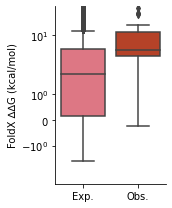

In [28]:
s.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['Exp.', 'Obs.'])
plt.tight_layout()

Ligand-binding interface test excluding high ∆∆G and calcium-binding mutations

In [29]:
s = d_oe.run_section(notch2_section_definition_egf11_12, lookup=excllook_interface, 
                      statistics=BinomTest())

In [30]:
s.get_results_dictionary()

{'gene': 'NOTCH2',
 'transcript_id': 'ENST00000256646',
 'chrom': '1',
 'section_id': '5mwb:A',
 'num_mutations': 6,
 'observed_median': 1.0,
 'observed_mean': 0.6666666666666666,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 1.0,
 'expected_mean_glob_k3': 0.23179988258816256,
 'mean_shift_glob_k3': 0.4348667840785041,
 'binom_glob_k3_pvalue': 0.028795671044638062,
 'binom_glob_k3_expected_proportion': 0.2317998825881626,
 'binom_glob_k3_observed_proportion': 0.6666666666666666,
 'binom_glob_k3_expected_count': 1.3907992955289754,
 'binom_glob_k3_observed_count': 4,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 4.0,
 'binom_glob_k3_expected_CI_low': 0.0,
 'binom_glob_k3_observed_CI_low': 2.0,
 'binom_glob_k3_observed_CI_high': 6.0}

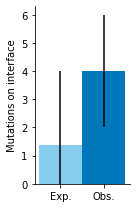

In [31]:
s.plot_binomial(figsize=(2, 3), show_legend=False, colours=[interface_observed_colour, interface_expected_colour])
plt.title("")
plt.ylabel('Mutations on interface')
hide_top_and_right_axes(plt.gca())
plt.tight_layout();

Calcium-binding mutation test excluding high ∆∆G and interface mutations. 

In [32]:
s = d_oe.run_section(notch2_section_definition_egf11_12, lookup=excllook_ca, 
                      statistics=BinomTest())

In [33]:
s.get_results_dictionary()

{'gene': 'NOTCH2',
 'transcript_id': 'ENST00000256646',
 'chrom': '1',
 'section_id': '5mwb:A',
 'num_mutations': 5,
 'observed_median': 1.0,
 'observed_mean': 0.6,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 1.0,
 'expected_mean_glob_k3': 0.1508178166040458,
 'mean_shift_glob_k3': 0.44918218339595417,
 'binom_glob_k3_pvalue': 0.02701250599203724,
 'binom_glob_k3_expected_proportion': 0.1508178166040458,
 'binom_glob_k3_observed_proportion': 0.6,
 'binom_glob_k3_expected_count': 0.754089083020229,
 'binom_glob_k3_observed_count': 3,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 3.0,
 'binom_glob_k3_expected_CI_low': 0.0,
 'binom_glob_k3_observed_CI_low': 1.0,
 'binom_glob_k3_observed_CI_high': 5.0}

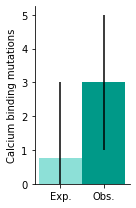

In [34]:
s.plot_binomial(figsize=(2, 3), show_legend=False, colours=[calcium_observed_colour, calcium_expected_colour])
plt.title("")
plt.ylabel('Calcium binding mutations')
hide_top_and_right_axes(plt.gca())
plt.tight_layout();

# All mutation categories

In [35]:
target_selection_string = 'protein and segid A and resid {} and name CA'.format(
    " ".join([str(int(p)) for p in notch2_section_definition_egf11_12['interface_residues']]))
notch2_section_definition_egf11_12['interface_residues_3D'] = target_selection_string

# Define the lookup that measure the distance in the structure from these selected residues
interface_lookup3D = StructureDistanceLookup(
    boolean=False,  # This time we use the distance
    target_key='interface_residues_3D', 
    name='Distance from interface residues (A)',
    
    # Uses the pdb file and SIFTS. Provide paths to directories including those files.
    pdb_directory=pdb_directory,
    sifts_directory=sifts_directory, 
    download_sifts=True   # Download the SIFTS file if not already in the directory

)

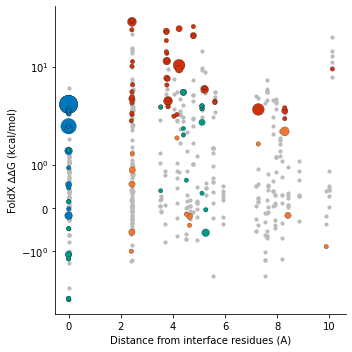

In [36]:
s_interface3D = d_skin.run_section(notch2_section_definition_egf11_12, statistics=[], lookup=interface_lookup3D)
s_ca_all = d_skin.run_section(notch2_section_definition_egf11_12, statistics=[], lookup=ca_lookup)
s_interface_all = d_skin.run_section(notch2_section_definition_egf11_12, statistics=[], lookup=interface_lookup)
s_fold_all = d_skin.run_section(notch2_section_definition_egf11_12, statistics=[], lookup=fold)


plot_scatter_two_scores(s_interface3D, s_fold_all, 
                        sections_for_colours=[s_fold_all, s_interface3D, s_ca_all], 
                        score_regions_for_colours=[[2, 100], [-1, 0.1], [0.9,1.1]],
                        score_region_colours=[foldx_observed_colour, interface_observed_colour, 
                                              calcium_observed_colour],
                        unobserved_mutation_colour=unobserved_colour, 
                        missense_mutation_colour=observed_colour,
                        plot_yscale='symlog', show_legend=False, figsize=(5, 5), unmutated_marker_size=10,
                        base_marker_size=20)
hide_top_and_right_axes()
plt.tight_layout()

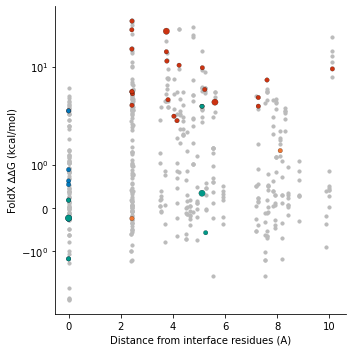

In [37]:
s_interface3D = d_oe.run_section(notch2_section_definition_egf11_12, statistics=[], lookup=interface_lookup3D)
s_ca_all = d_oe.run_section(notch2_section_definition_egf11_12, statistics=[], lookup=ca_lookup)
s_interface_all = d_oe.run_section(notch2_section_definition_egf11_12, statistics=[], lookup=interface_lookup)
s_fold_all = d_oe.run_section(notch2_section_definition_egf11_12, statistics=[], lookup=fold)

plot_scatter_two_scores(s_interface3D, s_fold_all, 
                        sections_for_colours=[s_fold_all, s_interface3D, s_ca_all], 
                        score_regions_for_colours=[[2, 100], [-1, 0.1], [0.9,1.1]],
                        score_region_colours=[foldx_observed_colour, interface_observed_colour, 
                                              calcium_observed_colour],
                        unobserved_mutation_colour=unobserved_colour, 
                        missense_mutation_colour=observed_colour,
                        plot_yscale='symlog', show_legend=False, figsize=(5, 5), unmutated_marker_size=10,
                        base_marker_size=20)
hide_top_and_right_axes()
plt.tight_layout()